# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Ход работы

Шаг 1. Загрузка данных

Шаг 2. Предобработка данных

Шаг 3. Исследовательский анализ данных

Шаг 4. Объединение таблиц

Шаг 5. Корреляционный анализ

Шаг 6. Использование пайплайнов

Шаг 7. Анализ важности признаков

Шаг 8. Сегментация покупателей

Шаг 9. Общий вывод

# Выполнение проекта

## Шаг 1. Загрузка данных 

In [10]:
#!pip install scikit-learn==1.1.0 -q
!pip install matplotlib -q
!pip install shap -q
!pip install phik -q

In [11]:
!pip install -U scikit-learn 

In [12]:
import shap
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from phik.report import plot_correlation_matrix
from phik import report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

RANDOM_STATE = 42

In [13]:
# Напишем функцию информации о df, чтобы не дублировать код

def df_info(data):
    display(data.sample(7))
    display(data.info())
    print('------------------------------------------')
    print('Количество явных дубликатов: ', data.duplicated().sum())
    print('------------------------------------------')
    print('Количество пропусков:', data.isna().sum())

**Описание df**

* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [14]:
market_file = pd.read_csv('/datasets/market_file.csv')
df_info(market_file)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
219,215567,Снизилась,стандарт,да,3.4,3,853,0.24,Домашний текстиль,2,6,5,4
106,215454,Снизилась,премиум,да,4.6,3,759,0.36,Косметика и аксесуары,1,4,8,5
343,215691,Снизилась,стандарт,нет,3.9,5,600,0.17,Домашний текстиль,1,7,4,10
496,215844,Снизилась,премиум,да,4.3,4,1041,0.99,Кухонная посуда,4,1,6,6
1022,216370,Прежний уровень,стандарт,нет,5.2,4,717,0.13,Кухонная посуда,2,3,5,9
473,215821,Снизилась,стандарт,да,4.7,5,508,0.28,Косметика и аксесуары,4,3,5,9
294,215642,Снизилась,премиум,да,3.8,4,962,0.30,Косметика и аксесуары,2,2,2,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

------------------------------------------
Количество явных дубликатов:  0
------------------------------------------
Количество пропусков: id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64


**Описание df**

* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка.
* Выручка — сумма выручки за период.

In [15]:
market_money = pd.read_csv('/datasets/market_money.csv')
df_info(market_money)

,id,Период,Выручка
1091,215711,препредыдущий_месяц,4444.0
2228,216090,текущий_месяц,5522.8
1459,215834,текущий_месяц,5574.2
3492,216512,препредыдущий_месяц,4939.0
3001,216348,текущий_месяц,6267.2
926,215656,текущий_месяц,5642.3
198,215414,препредыдущий_месяц,4747.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

------------------------------------------
Количество явных дубликатов:  0
------------------------------------------
Количество пропусков: id         0
Период     0
Выручка    0
dtype: int64


**Описание df**

* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксировано общее время.
* минут — значение времени, проведённого на сайте, в минутах.

In [16]:
market_time = pd.read_csv('/datasets/market_time.csv')
df_info(market_time)

,id,Период,минут
727,215711,текущий_месяц,9
1327,216011,текущий_месяц,10
1928,216312,текущий_месяц,14
994,215845,текущий_месяц,18
2165,216430,предыдцщий_месяц,17
1855,216275,предыдцщий_месяц,13
1680,216188,предыдцщий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

------------------------------------------
Количество явных дубликатов:  0
------------------------------------------
Количество пропусков: id        0
Период    0
минут     0
dtype: int64


**Описание df**

* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.

In [17]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
df_info(money)

,id,Прибыль
888,216236,4.39
452,215800,4.88
947,216295,2.68
1065,216413,4.86
1287,216635,3.15
651,215999,5.53
803,216151,6.13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

------------------------------------------
Количество явных дубликатов:  0
------------------------------------------
Количество пропусков: id         0
Прибыль    0
dtype: int64


**Промежуточный вывод:**

* Практически все названия df приведены к "змеиному_регистру" - откорректируем некоторые.
* Пропуски и явные дубликаты не выявлены.
* Типы данных заданы логично.
* Также сразу были заданы строка-разделитель между объектами и разделитель для чисел с плавающей точкой (запятую заменила на точку).

## Шаг 2. Предобработка данных

In [18]:
market_file = market_file.rename(columns={
    'Покупательская активность': 'Покупательская_активность',
    'Тип сервиса': 'Тип_сервиса',
    'Разрешить сообщать': 'Разрешить_сообщать'
})

display(market_file.columns)

Index(['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [19]:
market_time = market_time.rename(columns={
    'минут': 'Минут'
})

display(market_time.columns)

Index(['id', 'Период', 'Минут'], dtype='object')

In [20]:
# Проверим df на неявные дубликаты. для этого создадим функцию, которая будет выводить уникальные значения столбца

def dublicates(df):
    for i in df.columns:
        if df[i].dtype == 'object':
            print(i, df[i].unique())

In [21]:
dublicates(market_file)

Покупательская_активность ['Снизилась' 'Прежний уровень']
Тип_сервиса ['премиум' 'стандартт' 'стандарт']
Разрешить_сообщать ['да' 'нет']
Популярная_категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [22]:
# Избавимся дубликатов "стандартт" и "стандарт"

market_file['Тип_сервиса'].replace({'стандартт': 'стандарт'}, inplace=True)

display(market_file['Тип_сервиса'].unique())

array(['премиум', 'стандарт'], dtype=object)

In [23]:
dublicates(market_money)
dublicates(market_time)
dublicates(money)

Период ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
Период ['текущий_месяц' 'предыдцщий_месяц']


Дубликаты были обработаны

**Промежуточный вывод:**

* Были откорректированны названия столбцов, приведены к змеиному_регистру.
* Исправлен один неявный дубликат.
* Неявных дуликатов и пропусков в df не замечено.

## Шаг 3. Исследовательский анализ данных

Начнем с отбора клиентов с покупательской активностью не менее 3 месяцев. По ним и проведем исследовательский анализ.

Для отбора клиентов выберем тех, у котго нулевая выручка и исключим их из df.

In [24]:
id_clients = market_money.loc[market_money['Выручка'] == 0, 'id'].unique()
money = money[~money['id'].isin(id_clients)]
market_money = market_money.loc[~market_money['id'].isin(id_clients), :]
market_file = market_file.loc[~market_file['id'].isin(id_clients), :]
market_time = market_time.loc[~market_time['id'].isin(id_clients), :]

In [25]:
market_file.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1297.0,215998.986893,374.578554,215349.00,215675.00,215999.00,216323.0,216647.00
Маркет_актив_6_мес,1297.0,4.254433,1.015618,0.90,3.70,4.20,4.9,6.60
Маркет_актив_тек_мес,1297.0,4.009252,0.696048,3.00,4.00,4.00,4.0,5.00
Длительность,1297.0,602.993832,249.101456,121.00,410.00,607.00,806.0,1079.00
Акционные_покупки,1297.0,0.320547,0.249657,0.11,0.17,0.24,0.3,0.99
Средний_просмотр_категорий_за_визит,1297.0,3.267540,1.354623,1.00,2.00,3.00,4.0,6.00
Неоплаченные_продукты_штук_квартал,1297.0,2.841172,1.973451,0.00,1.00,3.00,4.0,10.00
Ошибка_сервиса,1297.0,4.184271,1.950973,0.00,3.00,4.00,6.0,9.00
Страниц_за_визит,1297.0,8.186584,3.977061,1.00,5.00,8.00,11.0,20.00


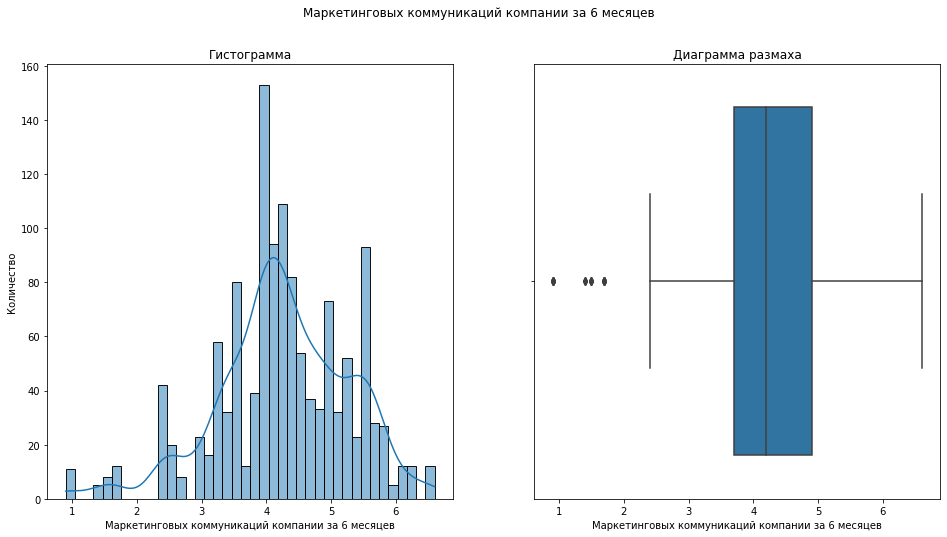

In [26]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = market_file,x = 'Маркет_актив_6_мес', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Маркетинговых коммуникаций компании за 6 месяцев')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = market_file,x = 'Маркет_актив_6_мес', ax=axs[1])
axs[1].set_xlabel('Маркетинговых коммуникаций компании за 6 месяцев')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Маркетинговых коммуникаций компании за 6 месяцев')
plt.show()

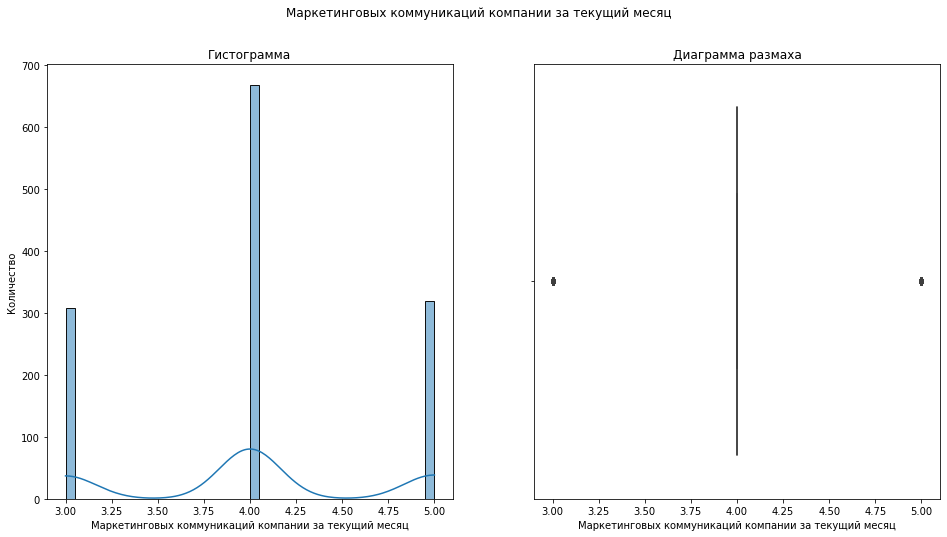

In [27]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = market_file,x = 'Маркет_актив_тек_мес', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Маркетинговых коммуникаций компании за текущий месяц')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = market_file,x = 'Маркет_актив_тек_мес', ax=axs[1])
axs[1].set_xlabel('Маркетинговых коммуникаций компании за текущий месяц')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Маркетинговых коммуникаций компании за текущий месяц')
plt.show()

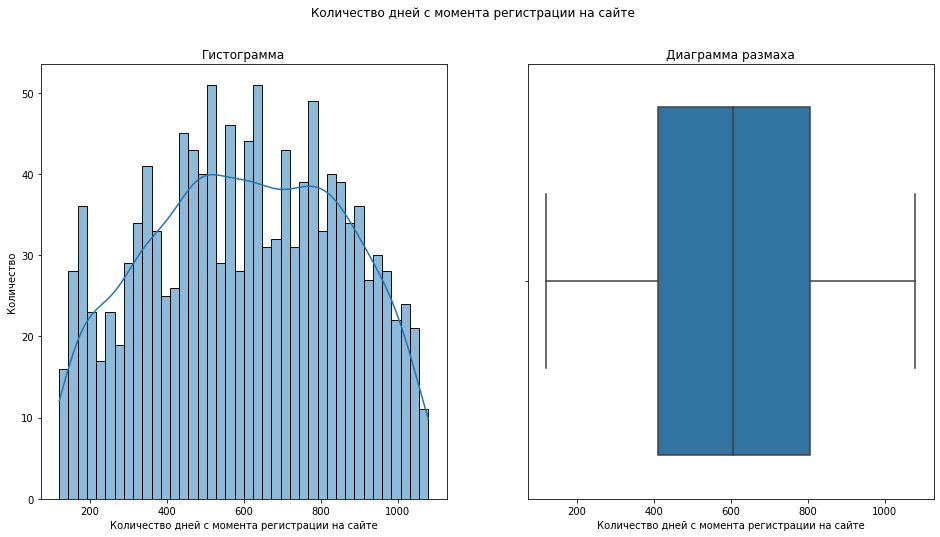

In [28]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = market_file,x = 'Длительность', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Количество дней с момента регистрации на сайте')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = market_file,x = 'Длительность', ax=axs[1])
axs[1].set_xlabel('Количество дней с момента регистрации на сайте')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Количество дней с момента регистрации на сайте')
plt.show()

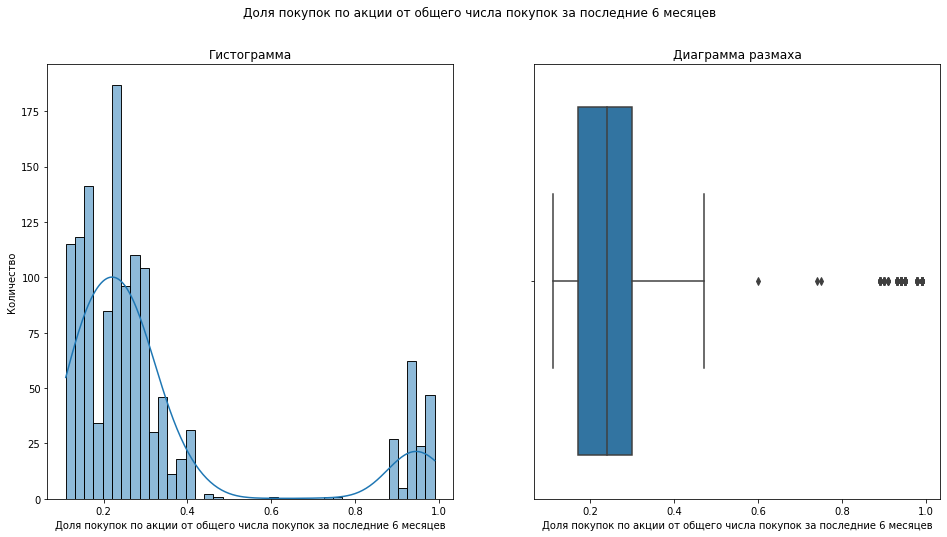

In [29]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = market_file,x = 'Акционные_покупки', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Доля покупок по акции от общего числа покупок за последние 6 месяцев')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = market_file,x = 'Акционные_покупки', ax=axs[1])
axs[1].set_xlabel('Доля покупок по акции от общего числа покупок за последние 6 месяцев')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Доля покупок по акции от общего числа покупок за последние 6 месяцев')
plt.show()

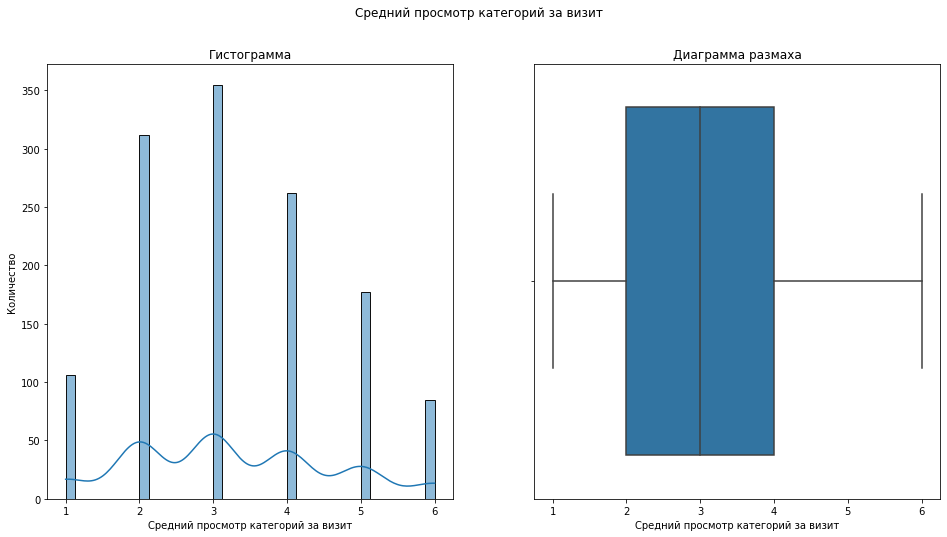

In [30]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = market_file,x = 'Средний_просмотр_категорий_за_визит', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Средний просмотр категорий за визит')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = market_file,x = 'Средний_просмотр_категорий_за_визит', ax=axs[1])
axs[1].set_xlabel('Средний просмотр категорий за визит')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Средний просмотр категорий за визит')
plt.show()

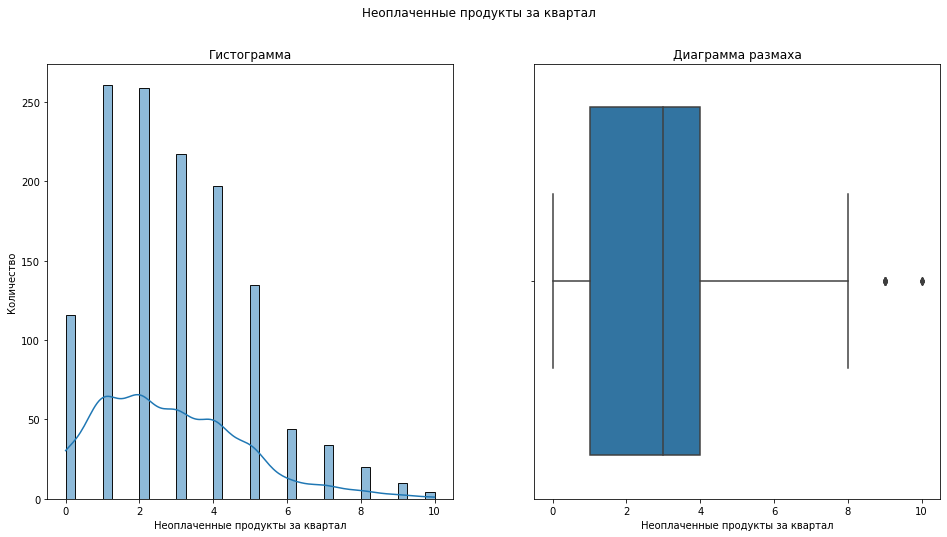

In [31]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = market_file,x = 'Неоплаченные_продукты_штук_квартал', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Неоплаченные продукты за квартал')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = market_file,x = 'Неоплаченные_продукты_штук_квартал', ax=axs[1])
axs[1].set_xlabel('Неоплаченные продукты за квартал')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Неоплаченные продукты за квартал')
plt.show()

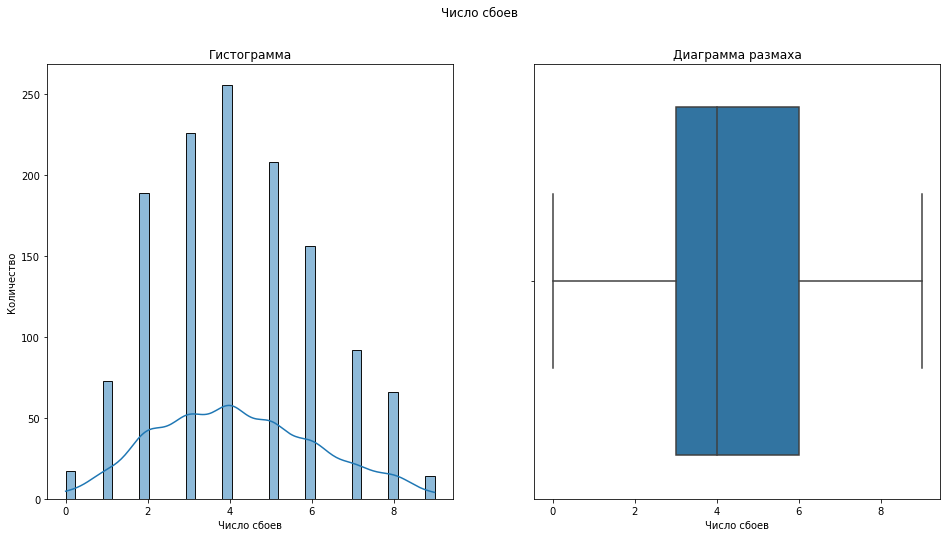

In [32]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = market_file,x = 'Ошибка_сервиса', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Число сбоев')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = market_file,x = 'Ошибка_сервиса', ax=axs[1])
axs[1].set_xlabel('Число сбоев')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Число сбоев')
plt.show()

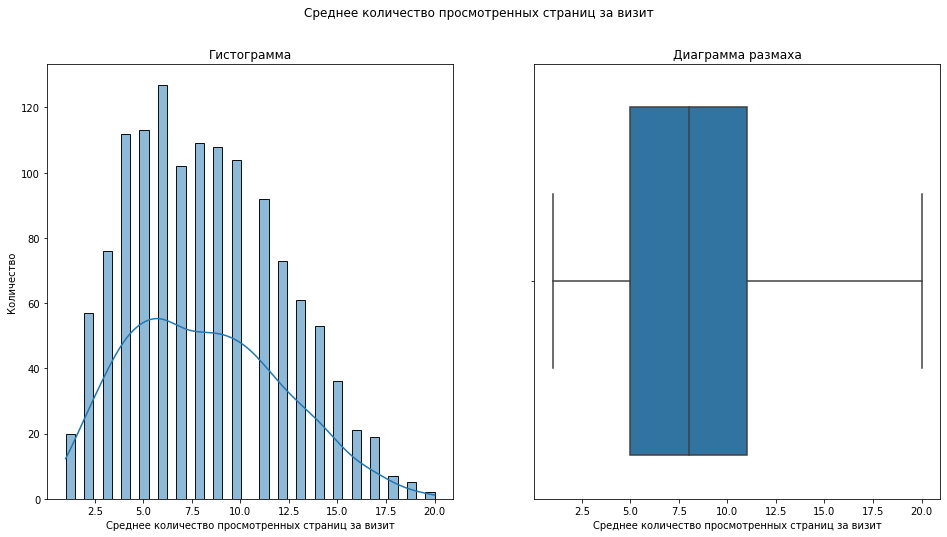

In [33]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = market_file,x = 'Страниц_за_визит', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Среднее количество просмотренных страниц за визит')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = market_file,x = 'Страниц_за_визит', ax=axs[1])
axs[1].set_xlabel('Среднее количество просмотренных страниц за визит')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Среднее количество просмотренных страниц за визит')
plt.show()

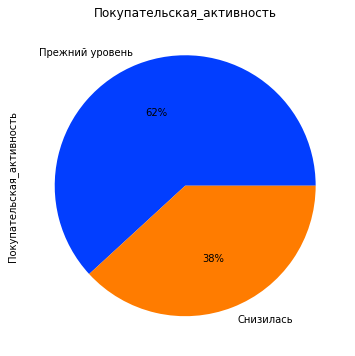

In [34]:
palette_color = sn.color_palette('bright') 
market_file['Покупательская_активность'].value_counts().plot(y = 'count', kind = 'pie', 
                                                             autopct='%1.0f%%', 
                                                             title = 'Покупательская_активность', 
                                                             colors = palette_color, 
                                                             figsize = (10, 6))
plt.show()

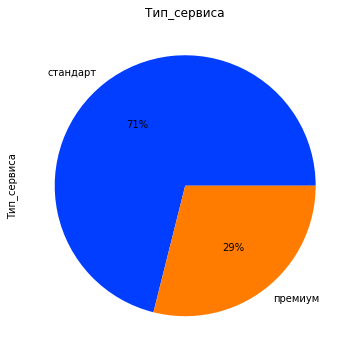

In [35]:
palette_color = sn.color_palette('bright') 
market_file['Тип_сервиса'].value_counts().plot(y = 'count', kind = 'pie', 
                                               autopct='%1.0f%%', 
                                               title = 'Тип_сервиса', colors = palette_color, 
                                               figsize = (10, 6))
plt.show()

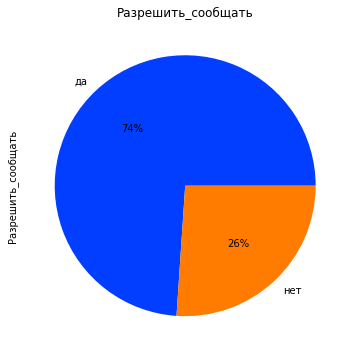

In [36]:
palette_color = sn.color_palette('bright') 
market_file['Разрешить_сообщать'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', 
                                                      title = 'Разрешить_сообщать', 
                                                      colors = palette_color, 
                                                      figsize = (10, 6))
plt.show()

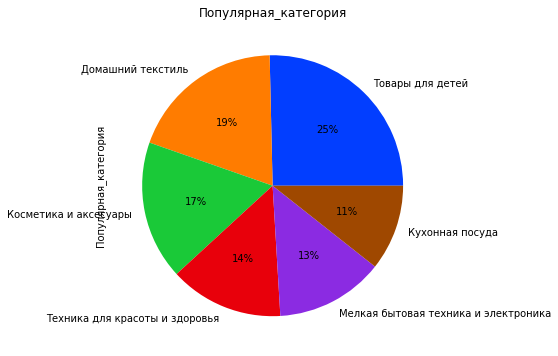

In [37]:
palette_color = sn.color_palette('bright') 
market_file['Популярная_категория'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Популярная_категория', colors = palette_color, figsize = (14, 6))
plt.show()

In [38]:
market_money.describe()

,id,Выручка
count,3891.000000,3891.000000
mean,215998.986893,5033.718890
std,374.482249,1768.471286
min,215349.000000,2758.700000
25%,215675.000000,4592.000000
50%,215999.000000,4959.000000
75%,216323.000000,5363.200000
max,216647.000000,106862.200000


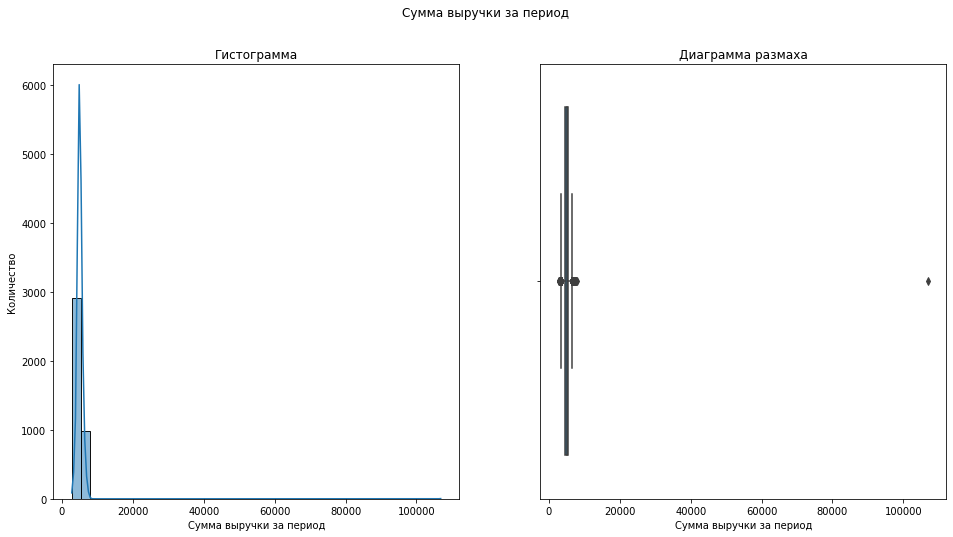

In [39]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = market_money,x = 'Выручка', ax=axs[0], bins = 40, kde = True)
axs[0].set_xlabel('Cумма выручки за период')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = market_money,x = 'Выручка', ax=axs[1])
axs[1].set_xlabel('Cумма выручки за период')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Cумма выручки за период')
plt.show()

Здесь можно заметить один выброс - одно аномально большое значение. Удаление одного значения не повлияет на дальнейшие расчеты

In [40]:
market_money = market_money.query('Выручка < 20000')

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



👍


 

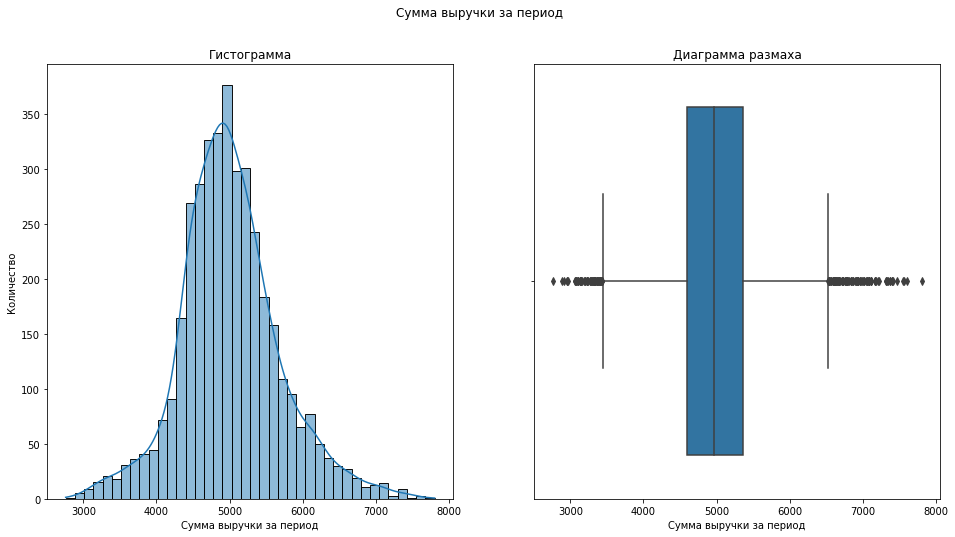

In [41]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = market_money,x = 'Выручка', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Cумма выручки за период')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = market_money,x = 'Выручка', ax=axs[1])
axs[1].set_xlabel('Cумма выручки за период')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Cумма выручки за период')
plt.show()

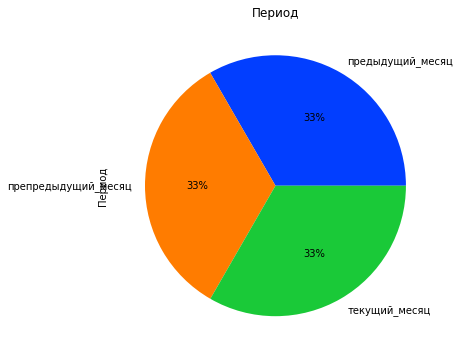

In [42]:
palette_color = sn.color_palette('bright') 
market_money['Период'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Период', colors = palette_color, figsize = (14, 6))
plt.show()

In [43]:
market_time.describe()

,id,Минут
count,2594.000000,2594.000000
mean,215998.986893,13.340401
std,374.506318,4.081999
min,215349.000000,4.000000
25%,215675.000000,10.000000
50%,215999.000000,13.000000
75%,216323.000000,16.000000
max,216647.000000,23.000000


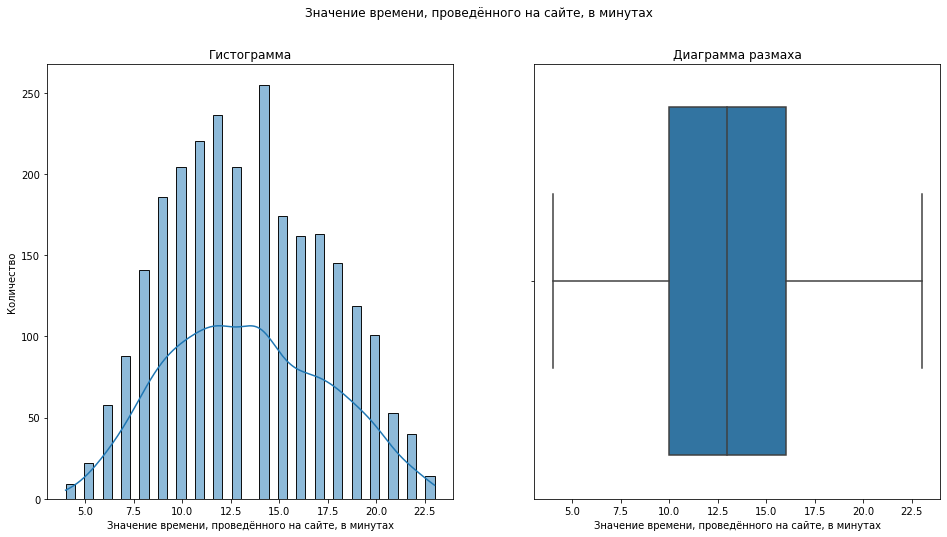

In [44]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = market_time,x = 'Минут', ax=axs[0], bins = 40, kde = True)
axs[0].set_xlabel('Значение времени, проведённого на сайте, в минутах')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = market_time,x = 'Минут', ax=axs[1])
axs[1].set_xlabel('Значение времени, проведённого на сайте, в минутах')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Значение времени, проведённого на сайте, в минутах')
plt.show()

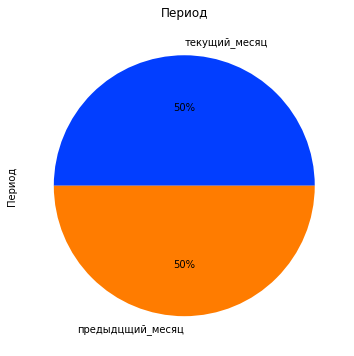

In [45]:
palette_color = sn.color_palette('bright') 
market_time['Период'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Период', colors = palette_color, figsize = (14, 6))
plt.show()

In [46]:
money.describe()

,id,Прибыль
count,1297.000000,1297.000000
mean,215998.986893,3.997610
std,374.578554,1.010813
min,215349.000000,0.860000
25%,215675.000000,3.300000
50%,215999.000000,4.040000
75%,216323.000000,4.670000
max,216647.000000,7.430000


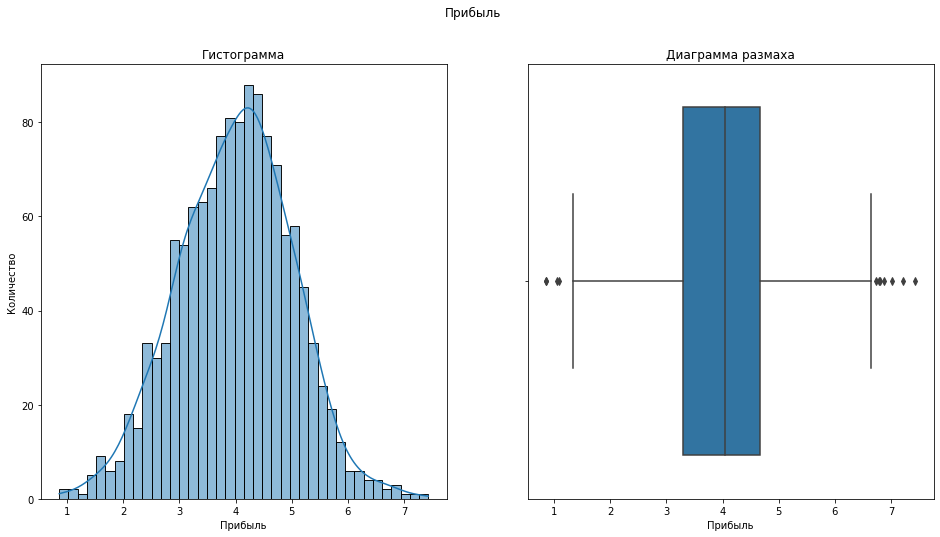

In [47]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = money,x = 'Прибыль', ax=axs[0], bins = 40, kde = True)
axs[0].set_xlabel('Прибыль')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = money,x = 'Прибыль', ax=axs[1])
axs[1].set_xlabel('Прибыль')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Прибыль')
plt.show()

**Промежуточный вывод:**

* Количество маркетиниговых коммуникаций компании находится в промежутке от 2 до 5, наиболее популярное количество - 4. Значения данного показатель имеют бимодальный вид.

* Покупательская активность в среднем не снизилась у тех, на кого приходилось больше маркетинговых коммуникаций.

* Большинство представленных клиентов зарегестрировались на платформе от 1-1.5 лет назад. 

* Как правило, 20% покупок клиентов - это покупки по акции, при этом есть клиенты, которые в более чем 80% случаев берут товары по акции. Данный показатель имеет бимодальное распределение.

* У клиентов, покупающих много товаров по акции, есть склонность иметь сниженную покупательскую активность;

* Наиболее часто просматривают 3 категории при покупке того или иного товара. Показатель распределен номрально;

* Наиболее часто оставляют неоплаченными 2 или 3 товара. Показатель распределён нормально со смещением влево;

* Покупатель как правило просматривает 6-8 страниц за визит. Показатель распределён относительно нормально со смещением влев.

* 70% клиентов имеют стандартную подписку;

* 74% клиентов дали согласие на рассылку дополнительных предложений о товаре.

* Четверть наиболее продаваемых товаров - товары для детей. Также популярны домашний тексить и косметика и аксессуары.

## Шаг 4. Объединение таблиц

In [48]:
transformed_market_money = market_money.pivot_table(index='id', 
                                                    columns='Период', 
                                                    values='Выручка', 
                                                    aggfunc='first').reset_index()
transformed_market_money.columns.name = None  # Убираем имя столбца 

In [49]:
transformed_market_money.shape


(1297, 4)

In [50]:
transformed_market_money = transformed_market_money.rename(columns={'id': 'id', 
                                                                    'предыдущий_месяц': 'выручка_предыдущий_месяц', 
                                                                    'препредыдущий_месяц': 'выручка_препредыдущий_месяц', 
                                                                    'текущий_месяц': 'выручка_текущий_месяц'})

In [51]:
transformed_market_money.shape

(1297, 4)

In [52]:
transformed_market_money.head()

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [53]:
transformed_market_time = market_time.pivot_table(index='id', columns='Период', values='Минут', aggfunc='first').reset_index()
transformed_market_time.columns.name = None  # Убираем имя столбца 
transformed_market_time = transformed_market_time.rename(columns={'id': 'id', 
                                                                  'предыдцщий_месяц': 'минуты_предыдущий_месяц', 
                                                                  'текущий_месяц': 'минуты_текущий_месяц'})

In [54]:
transformed_market_time.shape

(1297, 3)

In [55]:
market_file.shape

(1297, 13)

In [56]:
data = market_file.merge(transformed_market_money, on='id')
data.shape

(1297, 16)

In [57]:
data = data.merge(transformed_market_time, on='id')
data.shape

(1297, 18)

In [58]:
data.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [59]:
data.isnull().sum()

id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  1
минуты_предыдущий_месяц                0
минуты_текущий_месяц                   0
dtype: int64

In [60]:
data = data.dropna()

In [61]:
data.set_index('id', inplace=True)

In [62]:
data.shape

(1296, 17)

## Шаг 5. Корреляционный анализ

In [63]:
data.phik_matrix().style.background_gradient(cmap ='coolwarm')

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц']


,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
Покупательская_активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.505655,0.224154,0.749888,0.224638,0.497393,0.197213,0.685138,0.576770
Тип_сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.120027,0.079515,0.102594,0.000000,0.069704,0.124216,0.131814,0.000000
Разрешить_сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.195982,0.021839,0.042134,0.080842,0.000000,0.060907,0.038387,0.000000
Маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.289421,0.142401,0.396769,0.155476,0.315331,0.039795,0.363950,0.330601
Маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.144203,0.116946,0.000000,0.051824,0.000000,0.000000,0.107945,0.061410
Длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.125572,0.113200,0.147048,0.026448,0.101481
Акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.237962,0.000000,0.311418,0.060733,0.226381,0.071094,0.262324,0.250558
Популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.248620,0.000000,0.160300,0.252097,0.043528,0.237240,0.195233,0.089883
Средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.325578,0.070315,0.262271,0.098440,0.176828,0.092597,0.159837,0.182568
Неоплаченные_продукты_штук_квартал,0.505655,0.120027,0.195982,0.289421,0.144203,0.192611,0.237962,0.248620,0.325578,1.000000,0.032907,0.363760,0.249171,0.261016,0.230022,0.256632,0.232383


Признаки "выручка_текущий_месяц" и "выручка_предыдущий_месяц" являются мультиколлинеарными, но не с целевым признаком, также они не превышает значение 0.9, поэтому не будем их удалять

## Шаг 6. Использование пайплайнов

In [64]:
# Сначала обозначим, какие данные требуют масштабирования, а какие — кодирования
# Для этого введём обозначения для типов исходных данных
ohe_columns = ['Разрешить_сообщать', 'Популярная_категория']
ord_columns = ['Тип_сервиса']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка_препредыдущий_месяц','выручка_предыдущий_месяц','выручка_текущий_месяц' ,'минуты_предыдущий_месяц', 'минуты_текущий_месяц']

y = data['Покупательская_активность']
X = data.drop(['Покупательская_активность'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE
) 

In [65]:
# Создадим экземпляр класса LabelEncoder и применим кодировщик к тренировочной и тестовой выборкам

label_encoder = LabelEncoder()

In [66]:
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [67]:
# Добавляем OHE-кодирование в пайплайн

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse_output =False)
        )
    ]
) 

In [68]:
# Добавляем OHE-кодирование в пайплайн

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse_output =False)
        )
    ]
) 

In [69]:
# Добавляем Ordinal-кодирование в пайплайн

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='error'
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [70]:
# Объединяем шаги подготовки

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [71]:
# Создаём итоговый пайплайн для обучения модели

pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [72]:
# Перебираем гиперпараметры моделей

param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

In [73]:
# Запускаем автоматический подбор с помощью RandomizedSearchCV

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['Разрешить_сообщать',
                                                                                'Популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_befo...
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 10),
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

Используем метрику roc-auc, так как она имеет устойчивость к несбалансированным классам, независима от порога классификации и  ROC-кривая позволяет визуализировать качество модели и сравнивать ее с другими моделями.

In [74]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                            

In [75]:
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 2))

Метрика лучшей модели на тренировочной выборке: 0.87


In [76]:
y_predict = randomized_search.predict(X_test)
y_predict_proba = randomized_search.predict_proba(X_test)

In [77]:
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_predict), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.8


In [78]:
roc_auc_score(y_test, y_predict_proba[:, 1])

0.900012025012025

Лучшая модель - `KNeighborsClassifier(n_neighbors=17)`, значение метрики `roc_auc` - 0.9

## Шаг 7. Анализ важности признаков

In [79]:
X_train_shap = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)

In [80]:
shap.initjs()
best_model = randomized_search.best_estimator_.named_steps['models']
#best_model = randomized_search.best_estimator_
X_train_shap = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].fit_transform(X_train), 
    columns= pipe_final.named_steps['preprocessor'].get_feature_names_out()
)
X_test_shap = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].transform(X_test), 
    columns= pipe_final.named_steps['preprocessor'].get_feature_names_out()
)
model = KNeighborsClassifier(n_neighbors=17)
model.fit(X_train_shap, y_train)
explainer = shap.KernelExplainer(model.predict_proba, X_train_shap[:10])
shap_values = explainer(X_test_shap[:10])

  0%|          | 0/10 [00:00<?, ?it/s]

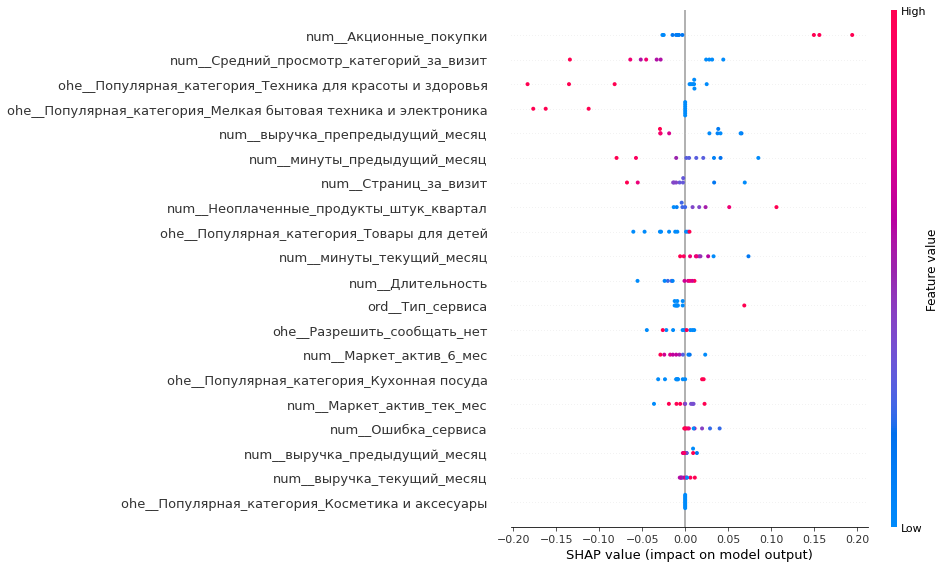

In [81]:
shap.plots.beeswarm(shap_values[:,:,1], max_display = 21) 

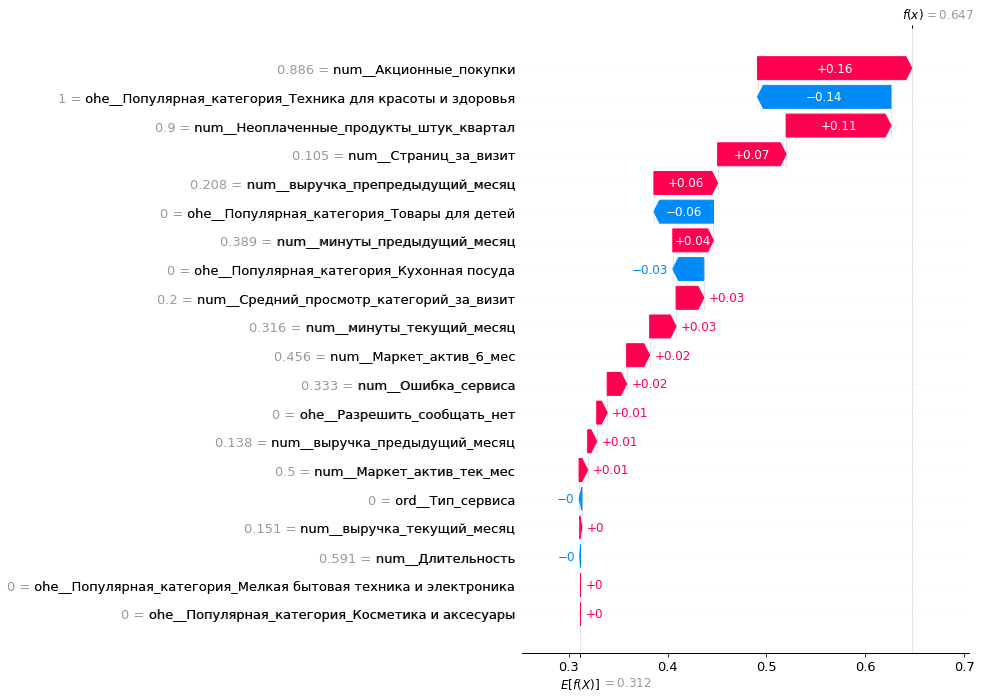

In [82]:
shap.plots.waterfall(shap_values[1,:,1], max_display = 21)

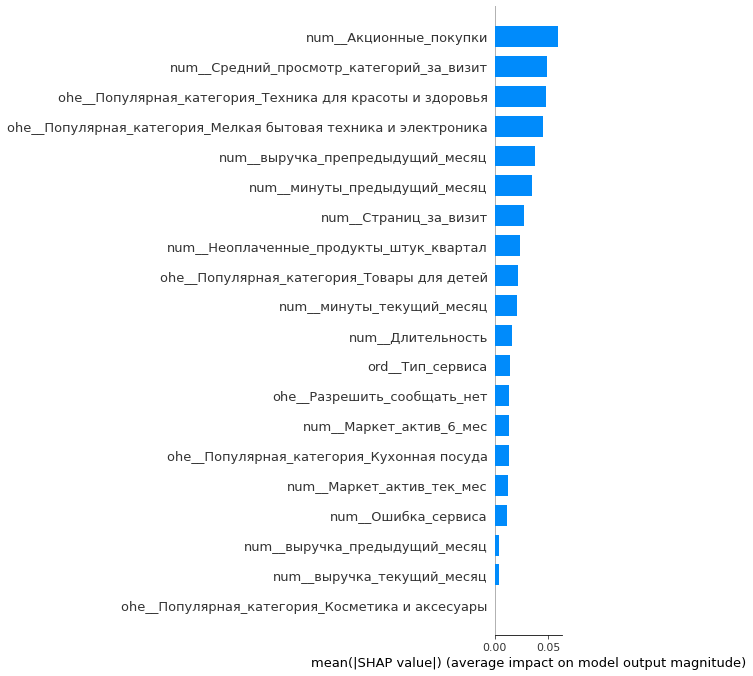

In [83]:
#shap.plots.bar(shap_values[:,:,1], max_display = 21)

shap.summary_plot(shap_values[:,:,1], plot_type='bar',max_display = 21)

**Промежуточные выводы:**
К малозначимым признакам отнесем:

    - Популярные категории (не считая бытовой техники и аксессуаров)
    - Выручка в текущем месяце
    - Ошибка сервиса

К наиболее значимые признакам:

    - Средний просмотр категорий за визит
    - Акционные покупки
    - Тип сервиса


* Тип сервиса тоже сильно влияет, так что возможно стоит давать больше каких-то бонусы тем, кто пользуется премиумом
* Средний просмотр категорий за визит - наиболее важный признак. Компании стоит обратить на это внимание, анализировать поведение пользователей и за тем персонализировать их предложения.

## Шаг 8. Сегментация покупателей

In [84]:
print(label_encoder.classes_)

['Прежний уровень' 'Снизилась']


In [85]:
pred_classes = [0, 1]
print(label_encoder.inverse_transform(pred_classes))

['Прежний уровень' 'Снизилась']


In [86]:
predicted = randomized_search.predict_proba(X_test)[:, 1]
X_test['predicted'] = predicted
X_test.reset_index(inplace=True)
segment = X_test.merge(money, on = 'id')

In [87]:
segment.head()

,id,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц,predicted,Прибыль
0,215950,стандарт,да,3.9,5,827,0.25,Мелкая бытовая техника и электроника,6,1,4,8,5124.5,4415.0,5869.4,11,13,0.000000,4.51
1,215698,стандарт,да,3.5,4,685,0.89,Техника для красоты и здоровья,2,9,3,3,3441.0,4429.0,3520.3,12,10,0.647059,5.10
2,216097,стандарт,да,5.0,4,698,0.27,Кухонная посуда,4,3,2,8,5353.5,4470.0,6249.2,15,6,0.411765,3.82
3,216381,стандарт,да,4.2,4,201,0.23,Мелкая бытовая техника и электроника,5,3,5,18,5592.0,5526.0,5779.2,13,4,0.058824,3.05
4,216510,премиум,да,4.9,5,723,0.91,Мелкая бытовая техника и электроника,2,4,6,9,5821.0,5290.0,6411.2,20,12,0.294118,3.76


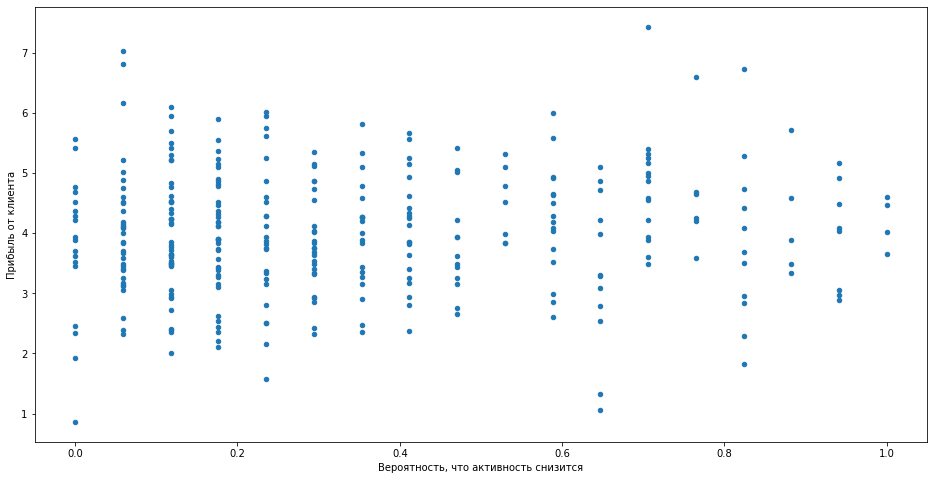

In [88]:
segment.plot.scatter(x = 'predicted', y = 'Прибыль', figsize=(16, 8))
plt.xlabel('Вероятность, что активность снизится')
plt.ylabel('Прибыль от клиента')
plt.show()

Рассмотрим только клиентов у которых высока вероятность, что их активность снизится, но при этом их прибыль больше средней

In [89]:
segment = segment[(segment['predicted'] >= 0.6) & (segment['Прибыль'] >= segment['Прибыль'].mean())]

In [90]:
segment.drop('id', axis = 1).phik_matrix().style.background_gradient(cmap ='coolwarm')

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'predicted', 'Прибыль']


,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц,predicted,Прибыль
Тип_сервиса,1.000000,0.491574,0.000000,0.000000,0.000000,0.266659,0.421262,0.000000,0.000000,0.519113,0.748032,0.314550,0.000000,0.636042,0.438575,0.294840,0.000000,0.000000
Разрешить_сообщать,0.491574,1.000000,0.221539,0.000000,0.131757,0.000000,0.094091,0.340856,0.776854,0.000000,0.136504,0.000000,0.000000,0.169610,0.797832,0.298514,0.292144,0.326175
Маркет_актив_6_мес,0.000000,0.221539,1.000000,0.000000,0.400908,0.534654,0.569051,0.640782,0.224940,0.000000,0.579962,0.000000,0.437009,0.234165,0.000000,0.410814,0.000000,0.000000
Маркет_актив_тек_мес,0.000000,0.000000,0.000000,1.000000,0.322569,0.423709,0.341118,0.508485,0.000000,0.000000,0.000000,0.715732,0.360195,0.000000,0.281503,0.683102,0.000000,0.000000
Длительность,0.000000,0.131757,0.400908,0.322569,1.000000,0.376419,0.000000,0.079655,0.000000,0.000000,0.000000,0.000000,0.000000,0.650694,0.000000,0.440371,0.000000,0.261585
Акционные_покупки,0.266659,0.000000,0.534654,0.423709,0.376419,1.000000,0.771392,0.253955,0.000000,0.000000,0.000000,0.540626,0.000000,0.000000,0.000000,0.258926,0.438698,0.000000
Популярная_категория,0.421262,0.094091,0.569051,0.341118,0.000000,0.771392,1.000000,0.000000,0.409990,0.000000,0.507753,0.000000,0.695348,0.431488,0.843469,0.413567,0.309060,0.000000
Средний_просмотр_категорий_за_визит,0.000000,0.340856,0.640782,0.508485,0.079655,0.253955,0.000000,1.000000,0.000000,0.000000,0.489866,0.000000,0.261896,0.000000,0.000000,0.546991,0.496585,0.000000
Неоплаченные_продукты_штук_квартал,0.000000,0.776854,0.224940,0.000000,0.000000,0.000000,0.409990,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.465234,0.000000
Ошибка_сервиса,0.519113,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.444762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


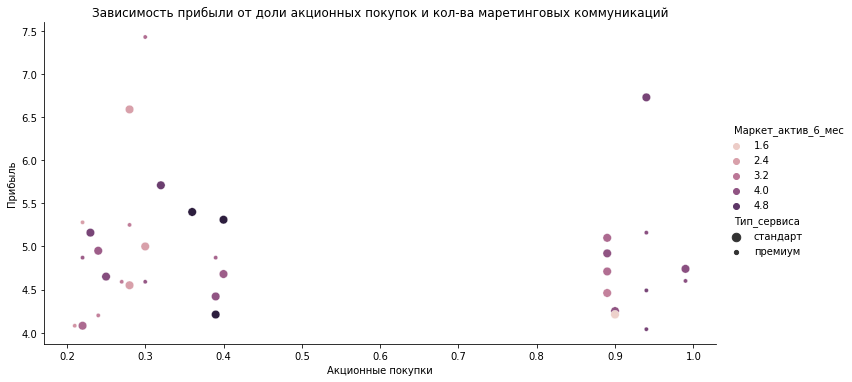

In [91]:
sn.relplot(data = segment, x = 'Акционные_покупки', 
           y ='Прибыль', hue = 'Маркет_актив_6_мес', 
           size = 'Тип_сервиса', aspect = 2)
plt.title('Зависимость прибыли от доли акционных покупок и кол-ва маретинговых коммуникаций')
plt.xlabel('Акционные покупки')
plt.ylabel('Прибыль')
plt.show()

In [92]:
segment.pivot_table(index = ['Страниц_за_визит', 'Тип_сервиса'])

id  predicted  Акционные_покупки  \
Страниц_за_визит Тип_сервиса                                                
1                стандарт     215435.500000   0.823529           0.640000   
2                премиум      215609.000000   0.852941           0.590000   
                 стандарт     215592.571429   0.806723           0.497143   
3                стандарт     215569.400000   0.741176           0.556000   
4                премиум      215560.000000   0.764706           0.260000   
                 стандарт     215589.500000   0.705882           0.570000   
5                премиум      215593.333333   0.764706           0.543333   
6                премиум      215556.666667   0.882353           0.736667   
                 стандарт     215457.250000   0.764706           0.610000   
7                премиум      215661.666667   0.803922           0.233333   
11               стандарт     215895.000000   0.705882           0.230000   

                              Длительность  Маркет_актив_6_мес  \
Страниц_за_визит Тип_сервиса                                     
1                стандарт       633.500000            4.300000   
2                премиум        388.500000            3.700000   
                 стандарт       460.857143            4.214286   
3                стандарт       623.200000            3.540000   
4                премиум        399.500000            2.900000   
                 стандарт       653.500000            2.650000   
5                премиум        930.666667            3.966667   
6                премиум        747.333333            3.766667   
                 стандарт       514.000000            3.675000   
7                премиум        905.000000            3.166667   
11               стандарт       517.000000            4.400000   

                              Маркет_актив_тек_мес  \
Страниц_за_визит Тип_сервиса                         
1                стандарт                 3.500000   
2                премиум                  4.000000   
                 стандарт                 4.571429   
3                стандарт                 4.200000   
4                премиум                  5.000000   
                 стандарт                 4.000000   
5                премиум                  4.333333   
6                премиум                  4.000000   
                 стандарт                 4.000000   
7                премиум                  3.666667   
11               стандарт                 5.000000   

                              Неоплаченные_продукты_штук_квартал  \
Страниц_за_визит Тип_сервиса                                       
1                стандарт                               5.000000   
2                премиум                                8.500000   
                 стандарт                               2.571429   
3                стандарт                               6.400000   
4                премиум                                4.500000   
                 стандарт                               3.500000   
5                премиум                                3.000000   
6                премиум                                4.333333   
                 стандарт                               4.500000   
7                премиум                                3.666667   
11               стандарт                               2.000000   

                              Ошибка_сервиса   Прибыль  \
Страниц_за_визит Тип_сервиса                             
1                стандарт           2.500000  4.335000   
2                премиум            2.500000  4.345000   
                 стандарт           3.000000  5.058571   
3                стандарт           5.600000  5.358000   
4                премиум            5.500000  6.355000   
                 стандарт           3.500000  4.580000   
5                премиум            5.333333  4.500000   
6                премиум            5.666667  5.003333   
            

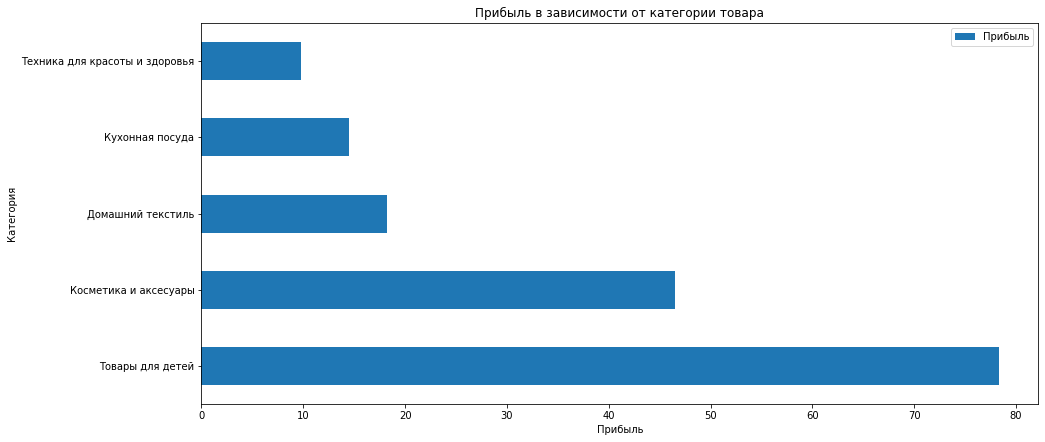

In [93]:
segment.groupby('Популярная_категория')['Прибыль'].sum().sort_values(ascending = False).plot(kind = 'barh', 
                                                                                             legend = True, 
                                                                                             figsize = (15, 7))
plt.title('Прибыль в зависимости от категории товара')
plt.ylabel('Категория')
plt.xlabel('Прибыль')
plt.show()

In [94]:
segment.pivot_table(index = 'Популярная_категория')

,id,predicted,Акционные_покупки,Длительность,Маркет_актив_6_мес,Маркет_актив_тек_мес,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Прибыль,Средний_просмотр_категорий_за_визит,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
Популярная_категория,,,,,,,,,,,,,,,,
Домашний текстиль,215536.5,0.838235,0.562500,496.000000,3.825000,3.750000,5.000000,3.000000,4.550000,2.000000,3.500000,4925.875000,4483.750000,5253.475000,9.750000,7.500000
Косметика и аксесуары,215598.0,0.764706,0.324444,663.000000,2.811111,4.111111,4.111111,3.777778,5.166667,2.111111,4.888889,5300.611111,4641.111111,5818.877778,9.444444,9.222222
Кухонная посуда,215539.0,0.823529,0.743333,839.333333,4.033333,4.000000,6.333333,5.000000,4.830000,2.333333,5.666667,5317.500000,4375.000000,5860.033333,12.666667,9.666667
Техника для красоты и здоровья,215598.5,0.647059,0.890000,763.500000,3.450000,4.000000,8.500000,5.500000,4.905000,2.000000,3.000000,3483.500000,4519.500000,3903.400000,13.000000,10.000000
Товары для детей,215575.0,0.797794,0.525625,551.125000,4.156250,4.437500,3.312500,3.937500,4.892500,2.187500,3.687500,4749.968750,4593.062500,5038.893750,8.000000,9.312500


Рассмотрим данный сегмент покупателей (он был выбран так как имеет большую прибыль, но при этом клиенты собираются уйти, т.е это потенциальная потеря большого количества средств для бизнеса). Рекомендации, которую можно дать бизнесу:

- Клиенты премиум-класса почти не используют акционные предложения, возможно стоит их как-то видоизменить, персонализировать, чтобы сделать их более популярными в этой группе
- Прибыль и удержание клиентов не сильно зависит от маркет. активности, а значит нужно сосредоточить своё внимание на более важных вещах
- Наиболее популярные категории товаров - "Товары для детей" и "Косметика и аксессуары". Но при этом доли акционных покупок там одни из самых низких. Для удержание клиентов этих категорий стоит добавить акций/персональных предложений.
- Пользователи, посещающие мало страниц за визит, имеют одни из самых наибольших вероятностей, на снижение своей активности. Необходимо придумать что-нибудь, для их дальнейшего удержания, например систему рекомендаций товаров.

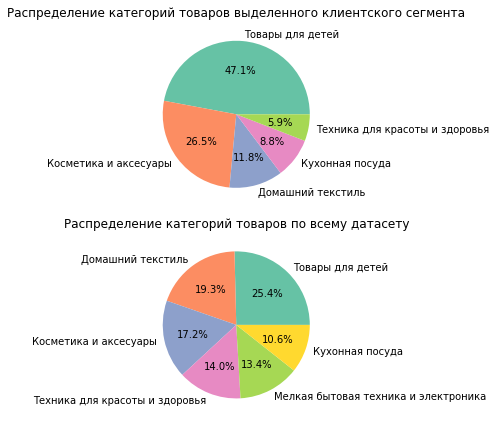

In [95]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].pie(
    x=segment['Популярная_категория'].value_counts(),
    labels=segment['Популярная_категория'].value_counts().index,
    autopct='%1.1f%%',
    colors=plt.cm.Set2.colors
)
axes[0].set_title('Распределение категорий товаров выделенного клиентского сегмента')

axes[1].pie(
    x=data['Популярная_категория'].value_counts(),
    labels=data['Популярная_категория'].value_counts().index,
    autopct='%1.1f%%',
    colors=plt.cm.Set2.colors
)
axes[1].set_title('Распределение категорий товаров по всему датасету')

plt.tight_layout()

plt.show()

Покупатели выделенного сегмента чаще покупают товары для детей и косметику и аксесуары, при этом доли покупок техники для красоты и здоровья, а также мелкой бытовой техники в разы меньше, чем по всему датасету. Можно также заметить, что по всему датасету категории распределены более равносерно.

**Рекомендация:** 

* можно стимулировать покупки товаров "проседающих категорий" с помощью скидок и акций для клиентов выделенного сегмента

## Шаг 9. Итоговый вывод

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. «В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. Перед нами стояла задача разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.\
Данные были проверены на дубликаты и пропуски. Был один неявный дубликат - он был устранён. Пропусков в датасетах не было. На стадии исследовательского анализа данных был удалён один выброс.\
Для поиска лучшей модели был написан пайплайн, в котором перебирались способы масштабирования данных, модели и гиперпараметры к ним. По итогу лучшей моделью оказалась - KNeighborsClassifier(n_neighbors=17).\
**При моделировании и принятии бизнесс-решений:**
- Компании следует обратить внимание на то, что акционные покупки сильно влияют на результат, так что, возможно следует устраивать больше акций.
- Тип сервиса тоже сильно влияет, так что возможно стоит давать больше каких-то бонусы тем, кто пользуется премиумом
- Средний просмотр категорий за визит - наиболее важный признак. Компании стоит обратить на это внимание, анализировать поведение пользователей и за тем персонализировать их предложения.

Также, для сегмента покупателей с высокой прибылью и высокой вероятностью снижения покупательской способности был проведён дополнительный анализ. Рекомендации, которую можно дать бизнесу:
- Клиенты премиум-класса почти не используют акционные предложения, возможно стоит их как-то видоизменить, персонализировать, чтобы сделать их более популярными в этой группе
- Прибыль и удержание клиентов не сильно зависит от маркет. активности, а значит нужно сосредоточить своё внимание на более важных вещах
- Наиболее популярные категории товаров - "Товары для детей" и "Косметика и аксессуары". Но при этом доли акционных покупок там одни из самых низких. Для удержание клиентов этих категорий стоит добавить акций/персональных предложений.
- Пользователи, посещающие мало страниц за визит, имеют одни из самых наибольших вероятностей, на снижение своей активности. Необходимо придумать что-нибудь, для их дальнейшего удержания, например систему рекомендаций товаров.
